# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from collections import defaultdict
from tqdm import tqdm

# Load Data

In [3]:
import pandas as pd

df = pd.read_csv('../dataset/weighted_score_above_08.csv')

df.head()

/var/folders/sr/kk6cvpy92zvfzcj5gr5l6c6h0000gn/T/ipykernel_18897/972847953.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../dataset/weighted_score_above_08.csv')


,recommendationid,appid,game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,...,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location
0,147449116,10,Counter-Strike,76561199183984450,51,12,2548,0,2480,1696305457,...,1,99,2,0.889438,0,1,0,0,1,NaN
1,147374264,10,Counter-Strike,76561198099573060,226,13,2369,0,2361,1696096555,...,1,122,8,0.914834,0,1,0,0,1,NaN
2,147357703,10,Counter-Strike,76561199080026894,118,23,13501,212,12957,1697630734,...,1,599,20,0.968375,3,1,0,0,1,NaN
3,147345102,10,Counter-Strike,76561198068970227,28,1,10668,640,9906,1698261011,...,1,59,12,0.826206,0,0,0,0,1,NaN
4,147284743,10,Counter-Strike,76561199137893460,19,5,543,10,526,1697810991,...,1,128,24,0.853612,0,1,0,0,1,NaN


In [4]:
# Subset the dataframe to include only 'appid' and 'game'
df_games = df[['appid', 'game']]

# Remove duplicates to ensure 'appid' is unique
df_games = df_games.drop_duplicates(subset='appid')

# Create dictionaries
appid2game = df_games.set_index('appid')['game'].to_dict()
game2appid = df_games.set_index('game')['appid'].to_dict()

# Delete df_games
del df_games

In [5]:
df = df[['appid', 'author_steamid', 'voted_up']]

# Exploratory Data Analysis

In [18]:
# Descriptive statistics
print("Descriptive Statistics:")
print(df.describe())

# Unique value counts for appid and author_steamid
print("\nUnique appid count:", df['appid'].nunique())
print("Unique author_steamid count:", df['author_steamid'].nunique())

Descriptive Statistics:
              appid  author_steamid       voted_up
count  4.980940e+05    4.980940e+05  498094.000000
mean   7.775869e+05    7.656120e+16       0.844403
std    5.691624e+05    3.890875e+08       0.362473
min    1.000000e+01    7.656120e+16       0.000000
25%    3.064600e+05    7.656120e+16       1.000000
50%    6.230800e+05    7.656120e+16       1.000000
75%    1.180600e+06    7.656120e+16       1.000000
max    2.627220e+06    7.656120e+16       1.000000

Unique appid count: 27315
Unique author_steamid count: 379636


In [ ]:
voted_up_counts = df['voted_up'].value_counts()
print("\nDistribution of voted_up:")
print(voted_up_counts)


Distribution of voted_up:
voted_up
1    420592
0     77502
Name: count, dtype: int64


In [7]:
print('hello')

hello


In [8]:
def build_data_structures(df):
    user2game = df.groupby('author_steamid')['appid'].apply(list).to_dict()
    game2user = df.groupby('appid')['author_steamid'].apply(list).to_dict()
    user_game2rating = {
        (int(row['author_steamid']), int(row['appid'])): float(row['voted_up'])
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Building rating dict")
    }
    return user2game, game2user, user_game2rating

In [ ]:
# Distribution of how many games a given user rates
user_game_counts = df.groupby('author_steamid')['appid'].count()
plt.figure(figsize=(10, 6))
sns.histplot(user_game_counts, bins=50, kde=False, color='blue')
plt.title('Distribution of Number of Games Rated by Users')
plt.xlabel('Number of Games Rated')
plt.ylabel('Number of Users')
plt.show()

# Distribution of how many people have rated a given game
game_user_counts = df.groupby('appid')['author_steamid'].count()
plt.figure(figsize=(10, 6))
sns.histplot(game_user_counts, bins=50, kde=False, color='green')
plt.title('Distribution of Number of Ratings per Game')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Games')
plt.show()

# Distribution of 'voted_up' (positive vs negative ratings)
plt.figure(figsize=(8, 5))
sns.countplot(x='voted_up', data=df, palette='pastel')
plt.title('Distribution of Voted Up (Positive vs Negative Ratings)')
plt.xlabel('Voted Up (1 = Positive, 0 = Negative)')
plt.ylabel('Count')
plt.show()

# Top 10 most rated games
top_rated_games = game_user_counts.sort_values(ascending=False).head(10)
top_rated_games_names = [appid2game.get(appid, f"Unknown Game ({appid})") for appid in top_rated_games.index]
plt.figure(figsize=(12, 6))
sns.barplot(x=top_rated_games, y=top_rated_games_names, palette='viridis')
plt.title('Top 10 Most Rated Games')
plt.xlabel('Number of Ratings')
plt.ylabel('Game')
plt.show()

# Top 10 most active users (users who rated the most games)
top_active_users = user_game_counts.sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_active_users.values, y=top_active_users.index, palette='magma')
plt.title('Top 10 Most Active Users')
plt.xlabel('Number of Games Rated')
plt.ylabel('User Steam ID')
plt.show()

In [9]:
print('hey')

hey


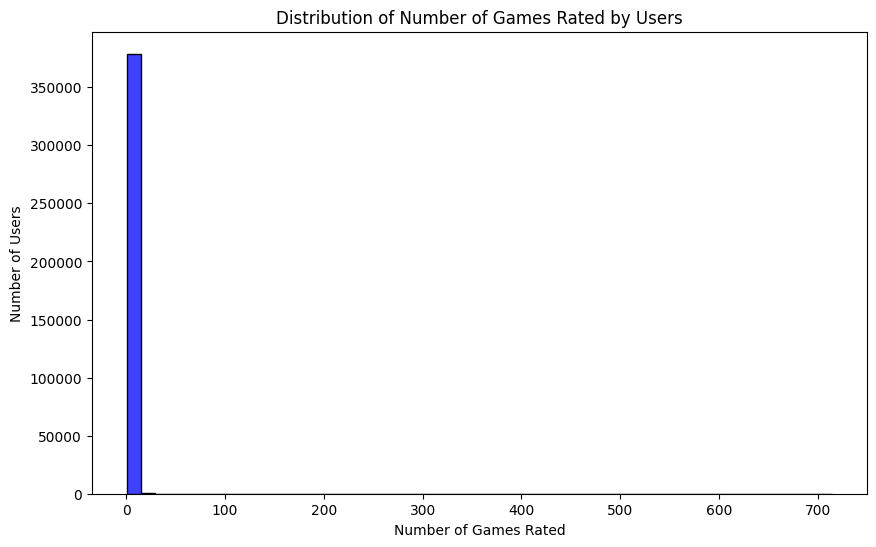

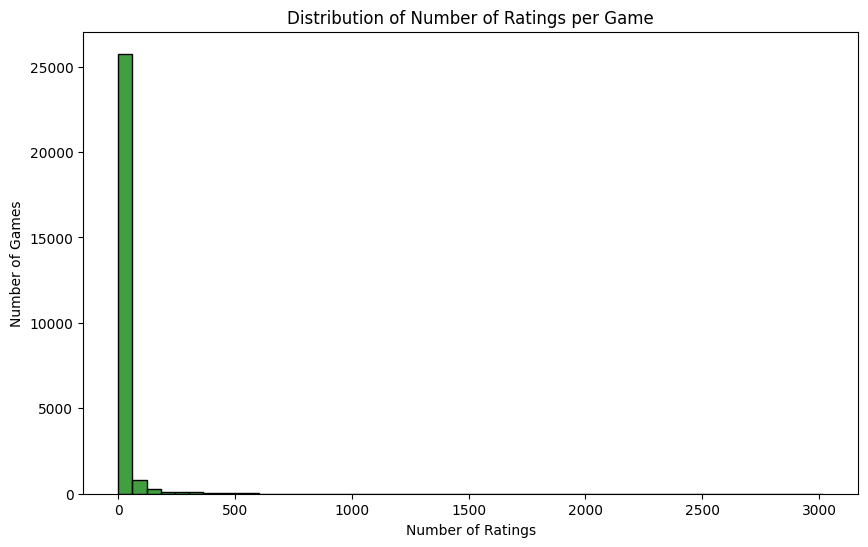

/var/folders/sr/kk6cvpy92zvfzcj5gr5l6c6h0000gn/T/ipykernel_18897/1303441229.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='voted_up', data=df, palette='pastel')


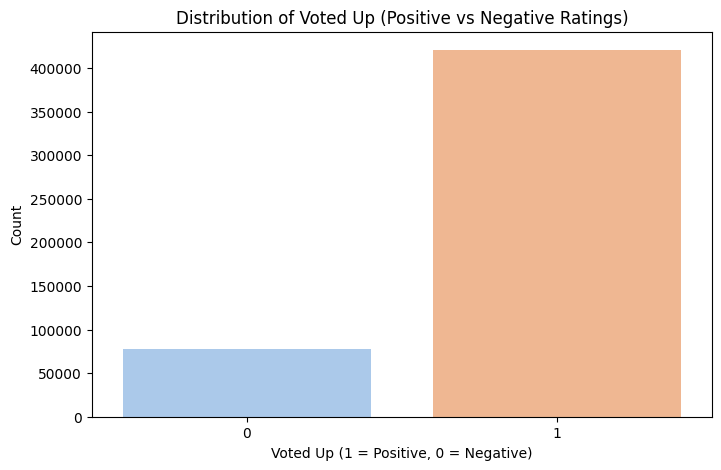

/var/folders/sr/kk6cvpy92zvfzcj5gr5l6c6h0000gn/T/ipykernel_18897/1303441229.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rated_games, y=top_rated_games_names, palette='viridis')


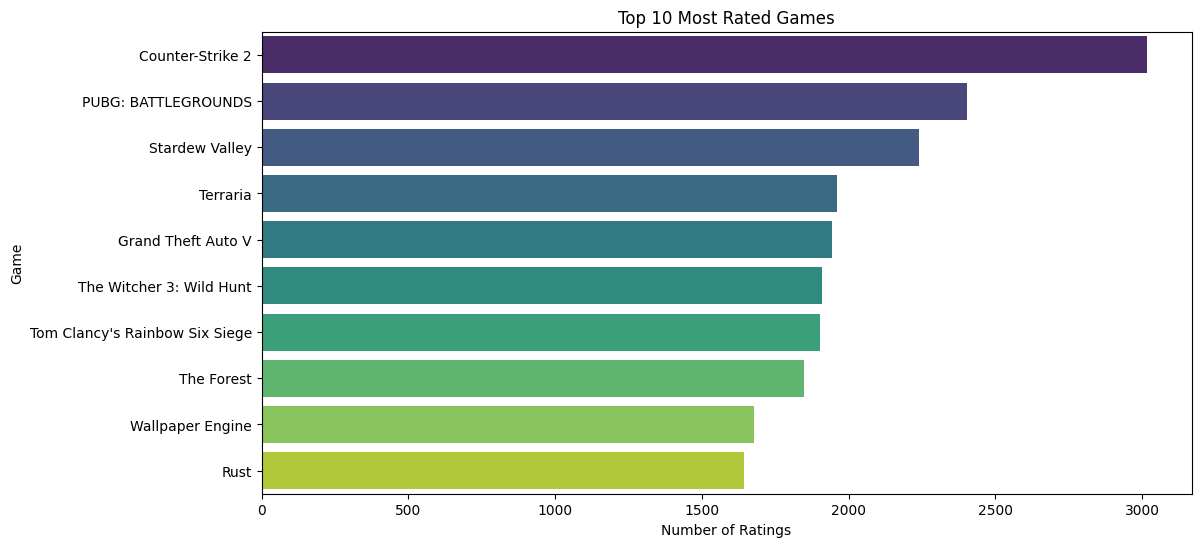

/var/folders/sr/kk6cvpy92zvfzcj5gr5l6c6h0000gn/T/ipykernel_18897/1303441229.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_active_users.values, y=top_active_users.index, palette='magma')


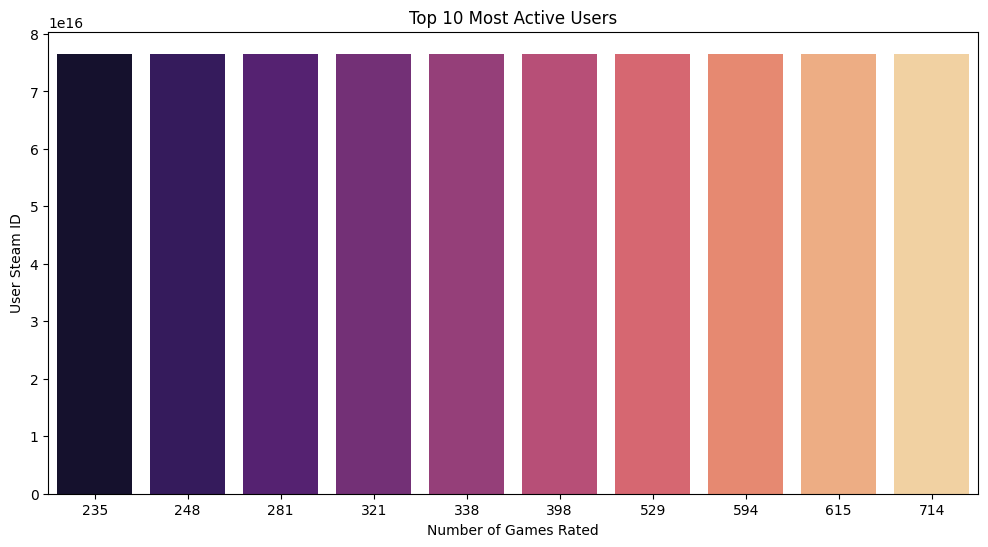

In [ ]:
# Distribution of how many games a given user rates
user_game_counts = df.groupby('author_steamid')['appid'].count()
plt.figure(figsize=(10, 6))
sns.histplot(user_game_counts, bins=50, kde=False, color='blue')
plt.title('Distribution of Number of Games Rated by Users')
plt.xlabel('Number of Games Rated')
plt.ylabel('Number of Users')
plt.show()

# Distribution of how many people have rated a given game
game_user_counts = df.groupby('appid')['author_steamid'].count()
plt.figure(figsize=(10, 6))
sns.histplot(game_user_counts, bins=50, kde=False, color='green')
plt.title('Distribution of Number of Ratings per Game')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Games')
plt.show()

# Distribution of 'voted_up' (positive vs negative ratings)
plt.figure(figsize=(8, 5))
sns.countplot(x='voted_up', data=df, palette='pastel')
plt.title('Distribution of Voted Up (Positive vs Negative Ratings)')
plt.xlabel('Voted Up (1 = Positive, 0 = Negative)')
plt.ylabel('Count')
plt.show()

# Top 10 most rated games
top_rated_games = game_user_counts.sort_values(ascending=False).head(10)
top_rated_games_names = [appid2game.get(appid, f"Unknown Game ({appid})") for appid in top_rated_games.index]
plt.figure(figsize=(12, 6))
sns.barplot(x=top_rated_games, y=top_rated_games_names, palette='viridis')
plt.title('Top 10 Most Rated Games')
plt.xlabel('Number of Ratings')
plt.ylabel('Game')
plt.show()

# Top 10 most active users (users who rated the most games)
top_active_users = user_game_counts.sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_active_users.values, y=top_active_users.index, palette='magma')
plt.title('Top 10 Most Active Users')
plt.xlabel('Number of Games Rated')
plt.ylabel('User Steam ID')
plt.show()


In [ ]:
print('Mean Number Of Games a User Rated:', user_game_counts.mean())

Mean Number Of Games a User Rated: 1.3120304712935549


In [17]:
users_rated_more_than_0 = user_game_counts[user_game_counts > 0].count()
print("Number of users who rated games:", users_rated_more_than_0)

users_rated_more_than_1 = user_game_counts[user_game_counts > 1].count()
print("Number of users who rated more than 1 games:", users_rated_more_than_1)

users_rated_more_than_2 = user_game_counts[user_game_counts > 2].count()
print("Number of users who rated more than 2 games:", users_rated_more_than_2)

users_rated_more_than_3 = user_game_counts[user_game_counts > 3].count()
print("Number of users who rated more than 3 games:", users_rated_more_than_3)

Number of users who rated games: 379636
Number of users who rated more than 1 games: 48309
Number of users who rated more than 2 games: 17289
Number of users who rated more than 3 games: 9052


# User-Based Collaborative Filtering

In [20]:
import numpy as np
import math
from tqdm import tqdm

def build_data_structures(df):
    user2game = df.groupby('author_steamid')['appid'].apply(list).to_dict()
    game2user = df.groupby('appid')['author_steamid'].apply(list).to_dict()
    user_game2rating = {
        (int(row['author_steamid']), int(row['appid'])): float(row['voted_up'])
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Building rating dict")
    }
    return user2game, game2user, user_game2rating

def compute_user_means(user2game, user_game2rating):
    global_means = {}
    for user in tqdm(user2game, desc="Computing user means"):
        ratings = [float(user_game2rating[(user, game)]) for game in user2game[user]]
        global_means[user] = np.mean(ratings) if ratings else 0.0
    return global_means

def pearson_similarity(target_user, other_user, user2game, user_game2rating, global_means, min_common):
    games_target = set(user2game[target_user])
    games_other = set(user2game[other_user])
    common_games = games_target & games_other

    if len(common_games) < min_common:
        return 0.0

    mu_target = global_means[target_user]
    mu_other = global_means[other_user]

    num, denom_target, denom_other = 0.0, 0.0, 0.0
    for game in common_games:
        r_t = user_game2rating[(target_user, game)]
        r_o = user_game2rating[(other_user, game)]
        dt = r_t - mu_target
        do = r_o - mu_other
        num += dt * do
        denom_target += dt ** 2
        denom_other += do ** 2

    if denom_target == 0 or denom_other == 0:
        return 0.0

    return num / (math.sqrt(denom_target) * math.sqrt(denom_other))

def compute_similarities(target_user, user2game, user_game2rating, global_means, min_common):
    similarities = {}
    for other_user in tqdm(user2game, desc=f"Computing similarities to user {target_user}"):
        if other_user != target_user:
            sim = pearson_similarity(target_user, other_user, user2game, user_game2rating, global_means, min_common)
            similarities[other_user] = sim
    return similarities

def predict_ratings(
    target_user, user2game, game2user, user_game2rating,
    global_means, similarity_scores, k=25
):
    games_target = set(user2game[target_user])
    candidate_games = [g for g in game2user if g not in games_target]
    predicted_ratings = {}

    for game in tqdm(candidate_games, desc="Predicting ratings"):
        raters = game2user[game]
        sim_rating_pairs = [
            (similarity_scores.get(user, 0), user_game2rating[(user, game)])
            for user in raters
            if user != target_user and similarity_scores.get(user, 0) != 0
        ]

        if not sim_rating_pairs:
            continue  # No valid raters

        sim_rating_pairs.sort(key=lambda x: x[0], reverse=True)
        top_pairs = sim_rating_pairs[:k]

        numerator = sum(sim * rating for sim, rating in top_pairs)
        denominator = sum(abs(sim) for sim, _ in top_pairs)

        predicted_rating = float(numerator) / denominator if denominator else 0.0
        predicted_ratings[game] = np.round(predicted_rating, 3)

    return predicted_ratings

def recommend_games(
    df, appid2game, min_common, target_user=None, top_n=10, k=25
):
    user2game, game2user, user_game2rating = build_data_structures(df)
    global_means = compute_user_means(user2game, user_game2rating)

    if target_user is None:
        target_user = next(iter(user2game))

    similarity_scores = compute_similarities(
        target_user, user2game, user_game2rating, global_means, min_common
    )
    score_vals = list(similarity_scores.values())
    print('Max similarity', max(score_vals))
    print('Similarity scores', score_vals[0])

    predicted_ratings = predict_ratings(
        target_user, user2game, game2user, user_game2rating,
        global_means, similarity_scores, k
    )

    if not predicted_ratings:
        print(f"No predictions available for user {target_user}. Try lowering `min_common`.")
        return []

    print('Max predicted rating score:', max(predicted_ratings.values()))

    top_recommendations = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)[:top_n]

    recommendations = [
        (appid2game.get(appid, f"Unknown Game ({appid})"), rating)
        for appid, rating in top_recommendations
    ]

    return recommendations

recs = recommend_games(df, appid2game, target_user=76561199183984450, top_n=10, min_common=1)
print("Top Recommendations:")
for game, score in recs:
    print(f"{game}: {score}")


Computing similarities to user 76561199183984450: 100%|██████████| 379636/379636 [00:00<00:00, 2342667.55it/s]


Max similarity 0.0
Similarity scores 0.0


Predicting ratings: 100%|██████████| 27312/27312 [00:00<00:00, 278512.15it/s]

No predictions available for user 76561199183984450. Try lowering `min_common`.
Top Recommendations:
